In [1]:
import os  # 用于处理文件和目录
import torch  # 导入PyTorch，用于构建和训练深度学习模型
import numpy as np  # 导入NumPy库，用于处理数值计算
from torch.utils.data import Dataset, DataLoader  # 导入PyTorch的数据处理模块
from PIL import Image  # 导入PIL库，用于图像文件的读取和处理
from torchvision import transforms  # 导入torchvision的transforms模块，用于图像预处理
from torch.utils.data.sampler import SubsetRandomSampler  # 导入用于数据采样的工具
import torch.nn as nn  # 导入PyTorch的神经网络模块
import torchvision.models as models  # 导入预训练模型

In [2]:
### 准备
# 检查CUDA是否可用，并选择设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# 定义图像预处理变换
transform = transforms.Compose([
    transforms.Resize((400, 400)),  # 将图像大小统一调整到400x400
    transforms.ToTensor()
])

cuda


In [3]:
# 数据集的获取与封装类
class ImgSeq(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []  # 用于存储完整图像路径
        self.labels = []  # 用于存储图像对应的标签
        self.folder_path=[]
        # 路径操作 遍历图片序列文件夹，收集数据和标签
        for index, sub_path_name in enumerate(['injFail', 'injSuccess']):
            dir_path = os.path.join(root_dir, sub_path_name)  # 构造文件夹路径
            for folder_name in os.listdir(dir_path):  # 遍历文件夹中的所有文件
                path = os.path.join(dir_path, folder_name)  # 构造序列文件夹的完整路径
                if os.path.isdir(path):  # 检查是否为目录
                    self.folder_path.append(path)
                    self.data.append([os.path.join(path, img) for img in sorted(os.listdir(path))])
                    # sorted保证序列的顺序性，防止序列图片被打乱
                    self.labels.append(index)  # 保存对应的标签（0为失败，1为成功）
    def __len__(self):# 定义类的长度返回方法
        return len(self.data)
    def __getitem__(self, idx): # 定义getitem方法 允许类使用索引操作
        img_seq = self.data[idx] # 取对应索引的图片序列
        images = [Image.open(img).convert('L') for img in img_seq]  # PIL库的图片操作 转化为灰度图
        images = [self.transform(img) for img in images]  # 对每个图像应用预处理变换
        images = torch.stack(images)  # 图像堆叠成新张量
        label = self.labels[idx]
        return images, label  # 返回处理后的图像堆叠和标签
    pass

In [4]:
### 所有网络模块的定义
# 定义CNN模块，用于特征提取
class SqCNN(nn.Module):
    def __init__(self):
        super(SqCNN, self).__init__()
        # 加载预训练的模型单通道输入ResNet-18预训练模型
        resnet = models.resnet18(pretrained=True)
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), bias=False)
        # 迁移学习，我们需要去除最后一个全连接层
        # 重用ResNet的特征提取能力，而用自己的分类层替换掉原有的分类层，以便适应新的任务或类别数。
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        # 添加Dropout层，用于减少过拟合
        self.dropout = nn.Dropout(p=0.3)
    def forward(self, x):
        # x的维度是[batch_size, seq_len, channels, height, width]
        # 正确的维度应该是：4 8 1 400 400
        batch_size, seq_len, c, h, w = x.size()
        # 合并批次和序列长度，使其适合CNN输入
        x = x.view(batch_size * seq_len, c, h, w)
        x = self.features(x)
        # 重新解放维度，还原批次和序列长度
        x = x.view(batch_size, seq_len, -1)
        x = self.dropout(x)
        return x
# 定义LSTM与注意力机制模块
class LSTM_Attention(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes):
        super(LSTM_Attention, self).__init__()
        # 定义LSTM层
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        # 添加Dropout层
        self.dropout = nn.Dropout(p=0.3)
        # 定义注意力层，用于为每个时间步的隐藏状态分配权重
        self.attention_layer = nn.Linear(hidden_dim, 1)
        # 定义全连接层，用于分类
        self.fc = nn.Linear(hidden_dim, num_classes)
    def forward(self, x):
        # 通过LSTM处理输入
        lstm_out, _ = self.lstm(x)
        # 应用Dropout
        lstm_out = self.dropout(lstm_out)
        # 生成注意力权重
        attention_weights = torch.softmax(self.attention_layer(lstm_out), dim=1)
        # 计算加权的上下文向量
        context_vector = torch.sum(lstm_out * attention_weights, dim=1)
        # 通过全连接层得到最终输出
        out = self.fc(context_vector)
        return out
# 整体模型结构 串联CNN和LSTM两个模型
class CNNLSTM(nn.Module):
    def __init__(self):
        super(CNNLSTM, self).__init__()
        # 初始化CNN特征提取器
        self.cnn = SqCNN()
        # 初始化LSTM与注意力机制模块
        self.lstm_attention = LSTM_Attention(input_dim=512, hidden_dim=128, num_layers=1, num_classes=2)
    def forward(self, x):
        # 从CNN获取特征
        cnn_features = self.cnn(x)
        # 使用特征通过LSTM和注意力机制模块得到输出
        output = self.lstm_attention(cnn_features)
        return output

In [5]:
# 定义函数用于创建训练和验证数据的采样器
def get_train_val_sampler(train_dataset):
    dataset_size = len(train_dataset)  # 获取数据集的大小
    indices = list(range(dataset_size))  # 创建索引列表
    np.random.shuffle(indices)  # 随机打乱索引
    split = int(np.floor(0.15 * dataset_size))  # 计算验证集大小为数据集的15%
    train_indices, val_indices = indices[split:], indices[:split]  # 分割训练集和验证集索引
    # 创建SubsetRandomSampler对象，这些对象将被用于DataLoader以抽样数据
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)
    return train_sampler, valid_sampler  # 返回训练集和验证集的采样器
# 定义函数用于训练和验证模型
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=100):
    train_losses_list=[];train_accuracy_list=[]
    valid_losses_list=[];valid_accuracy_list=[]
    for epoch in range(epochs):  # 迭代指定的轮次
        model.train()  # 设置模型为训练模式
        running_loss = 0.0
        correct = 0  # 记录正确预测的数量
        total = 0  # 记录处理的总样本数
        for images, labels in train_loader:  # 从训练加载器中迭代数据
            images, labels = images.to(device), labels.to(device)  # 移动数据至设备
            optimizer.zero_grad()  # 梯度清零
            outputs = model(images)  # 前向传播
            loss = criterion(outputs, labels)  # 计算损失
            loss.backward()  # 反向传播
            # max_grad_norm = 5  # 设置梯度裁剪阈值
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)  # 应用梯度裁剪
            optimizer.step()  # 更新模型参数
            running_loss += loss.item()  # 累加损失
            _, predicted = outputs.max(1)  # 获取预测结果
            total += labels.size(0)  # 更新总样本数
            correct += predicted.eq(labels).sum().item()  # 更新正确预测数
        average_loss = running_loss / len(train_loader)  # 计算平均损失
        # 设置模型为评估模式
        model.eval()
        with torch.no_grad():  # 不计算梯度
            val_loss, val_correct, val_total = 0, 0, 0
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {average_loss:.4f},Train Acc:{correct/total*100:.2f}%, Val Loss: {val_loss/val_total:.4f}, Val Acc: {val_correct/val_total*100:.2f}%')
        train_losses_list.append(average_loss),train_accuracy_list.append(correct/total)
        valid_losses_list.append(val_loss/val_total),valid_accuracy_list.append(val_correct/val_total)
        pass
    return train_losses_list,train_accuracy_list,valid_losses_list,valid_accuracy_list

In [6]:
# main
train_dataset = ImgSeq(root_dir='injection-dataset_train', transform=transform)
train_sampler, val_sampler = get_train_val_sampler(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=4, sampler=train_sampler, num_workers=0)
valid_loader = DataLoader(train_dataset, batch_size=4, sampler=val_sampler, num_workers=0)
model = CNNLSTM().to(device)  # 创建模型并转移到设备上
criterion = nn.CrossEntropyLoss()  # 交叉熵损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)  # Adam优化器

C:\Users\29797\.conda\envs\pytorch_use\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\29797\.conda\envs\pytorch_use\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# 训练模型
epochs=100
train_losses_list,train_accuracy_list,valid_losses_list,valid_accuracy_list=train_model(model, train_loader, valid_loader, criterion, optimizer,epochs)  # 开始训练和验证模型

Epoch 1/100, Train Loss: 0.6863,Train Acc:52.94%, Val Loss: 0.1706, Val Acc: 50.00%
Epoch 2/100, Train Loss: 0.5550,Train Acc:80.88%, Val Loss: 0.1684, Val Acc: 58.33%
Epoch 3/100, Train Loss: 0.3868,Train Acc:95.59%, Val Loss: 0.2313, Val Acc: 50.00%
Epoch 4/100, Train Loss: 0.3176,Train Acc:95.59%, Val Loss: 0.2009, Val Acc: 58.33%
Epoch 5/100, Train Loss: 0.2544,Train Acc:92.65%, Val Loss: 0.0431, Val Acc: 100.00%
Epoch 6/100, Train Loss: 0.2744,Train Acc:89.71%, Val Loss: 0.0432, Val Acc: 91.67%
Epoch 7/100, Train Loss: 0.2311,Train Acc:89.71%, Val Loss: 0.0410, Val Acc: 100.00%
Epoch 8/100, Train Loss: 0.3607,Train Acc:80.88%, Val Loss: 0.0637, Val Acc: 91.67%
Epoch 9/100, Train Loss: 0.2313,Train Acc:94.12%, Val Loss: 0.0567, Val Acc: 83.33%
Epoch 10/100, Train Loss: 0.1827,Train Acc:94.12%, Val Loss: 0.0244, Val Acc: 100.00%
Epoch 11/100, Train Loss: 0.1777,Train Acc:92.65%, Val Loss: 0.0188, Val Acc: 100.00%
Epoch 12/100, Train Loss: 0.1533,Train Acc:95.59%, Val Loss: 0.0588, V

In [8]:
# 保存训练好的模型
model_name='model1.pth'
torch.save(model.state_dict(), model_name)

In [9]:
# 加载模型函数we
def load_model(model_path):
    model = CNNLSTM()
    model.load_state_dict(torch.load(model_path))  # 加载模型参数
    model.eval()  # 模型设为评估模式
    return model
# 预测函数，并计算准确率
def predict(model, data_loader):
    model.eval()  # 模型设为评估模式
    correct = 0
    total = 0
    results = []
    model = model.to(device)
    with torch.no_grad():  # 禁用梯度计算
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)  # 前向传播
            _, predicted = outputs.max(1)  # 获取预测结果
            results.extend(predicted.cpu().numpy())  # 将结果存入列表
            # 累计正确的预测数量
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()  # 累加正确预测数
            pass
        pass
    accuracy = correct / total
    return results, accuracy
# 加载测试数据集
test_dataset = ImgSeq(root_dir='injection-dataset_test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)
# 加载训练好的模型
model = load_model(model_name)
# 进行预测并计算准确率
predictions, accuracy = predict(model, test_loader)
# 输出预测结果
for i, prediction in enumerate(predictions):
    print(f'{test_dataset.folder_path[i]} : {"Success" if prediction == 1 else "Fail"}')
print(f'Accuracy: {accuracy * 100:.2f}%')

injection-dataset_test\injFail\MyVideo_33 : Fail
injection-dataset_test\injFail\MyVideo_34 : Fail
injection-dataset_test\injFail\MyVideo_35 : Fail
injection-dataset_test\injFail\MyVideo_36 : Fail
injection-dataset_test\injFail\MyVideo_37 : Fail
injection-dataset_test\injFail\MyVideo_38 : Fail
injection-dataset_test\injFail\MyVideo_39 : Fail
injection-dataset_test\injFail\MyVideo_40 : Fail
injection-dataset_test\injSuccess\MyVideo_33 : Success
injection-dataset_test\injSuccess\MyVideo_34 : Success
injection-dataset_test\injSuccess\MyVideo_35 : Success
injection-dataset_test\injSuccess\MyVideo_36 : Success
injection-dataset_test\injSuccess\MyVideo_37 : Success
injection-dataset_test\injSuccess\MyVideo_38 : Success
injection-dataset_test\injSuccess\MyVideo_39 : Success
injection-dataset_test\injSuccess\MyVideo_40 : Success
Accuracy: 100.00%


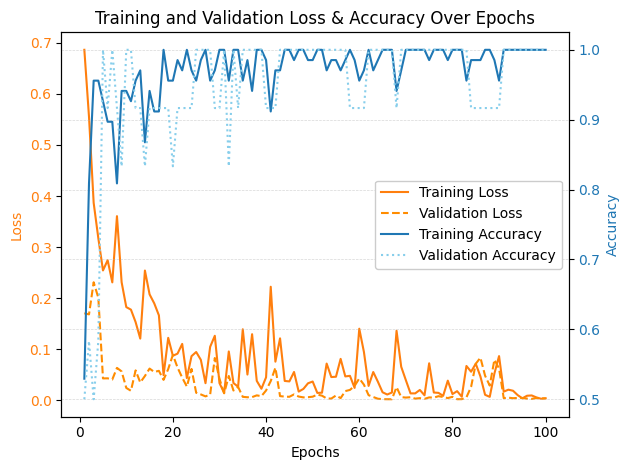

In [10]:
import matplotlib.pyplot as plt
# 创建图表
epochs_list=[i for i in range(1,epochs+1)]
fig, ax1 = plt.subplots(facecolor='white')
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
# 左边y轴Loss，使用暖色调
color_loss = 'tab:orange'
ax1.set_xlabel('Epochs', color='black')
ax1.set_ylabel('Loss', color=color_loss)
ax1.plot(epochs_list, train_losses_list, label='Training Loss', color=color_loss)
ax1.plot(epochs_list, valid_losses_list, label='Validation Loss', linestyle='--', color='darkorange')
ax1.tick_params(axis='y', labelcolor=color_loss)

# 创建第二个y轴，用于Accuracy，使用冷色调
ax2 = ax1.twinx()
color_acc = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color_acc)
ax2.plot(epochs_list, train_accuracy_list, label='Training Accuracy', color=color_acc)
ax2.plot(epochs_list, valid_accuracy_list, label='Validation Accuracy', linestyle=':', color='skyblue')
ax2.tick_params(axis='y', labelcolor=color_acc)
# 设置标题，并优化图例位置
plt.title('Training and Validation Loss & Accuracy Over Epochs', color='black')
fig.tight_layout()
handles, labels = [], []
for ax in [ax1, ax2]:
    for h, l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)
plt.legend(handles, labels, loc='center right', framealpha=1)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
# 显示图形
plt.show()